In [1]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

from torchinfo import summary

sns.set(style='darkgrid', font_scale=1.4)

<h1>Часть 1. Датасет moons</h1>

In [2]:
X, y = make_moons(n_samples=10**4, random_state=42, noise=0.1)

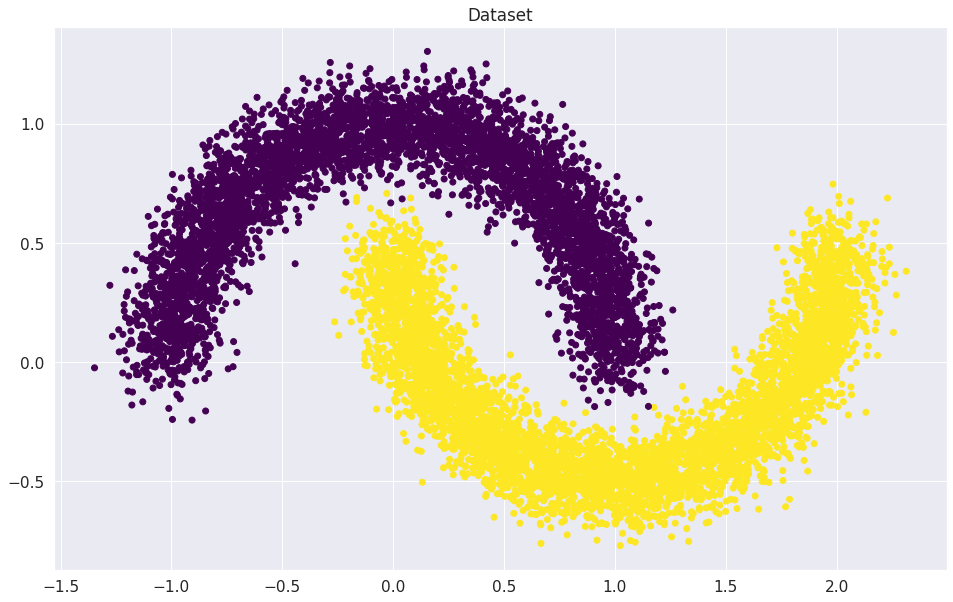

In [3]:
plt.figure(figsize=(16, 10))
plt.title('Dataset')
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis')
plt.show()

<p>Разбиение данных</p>

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

<p>Переведем данные в тензоры torch</p>

In [5]:
X_train_t = torch.from_numpy(X_train)
y_train_t = torch.from_numpy(y_train)
X_val_t = torch.from_numpy(X_val)
y_val_t = torch.from_numpy(y_val)

<p><b>Загрузка данных</b></p>
В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1. `Dataset` загружает каждый объект по отдельности.

2. `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`.

In [6]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

<h3> Реализация логистической регрессии </h3> 

In [7]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(in_features))
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.ones(1, out_features), requires_grad=True)
            
    def forward(self, x):
        x = x @ self.weights
        if self.bias:
            x += self.bias
        return x

In [8]:
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

In [9]:
summary(linear_regression, (1, 1, 2))

Layer (type:depth-idx)                   Output Shape              Param #
LinearRegression                         [1, 1]                    3
Total params: 3
Trainable params: 3
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

<h3>Обучение</h3>

In [50]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp = linear_regression(X_batch.float())
        loss = loss_function(outp, y_batch.float())
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        probabilities = torch.sigmoid(outp)
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)
        
        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f'Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}')
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f'\nIteration: {it + epoch * len(train_dataloader)}.Convergence.Stopping iterations')
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 0.8671875

Iteration: 47.Convergence.Stopping iterations


<h3>Визуализируем результаты</h3>

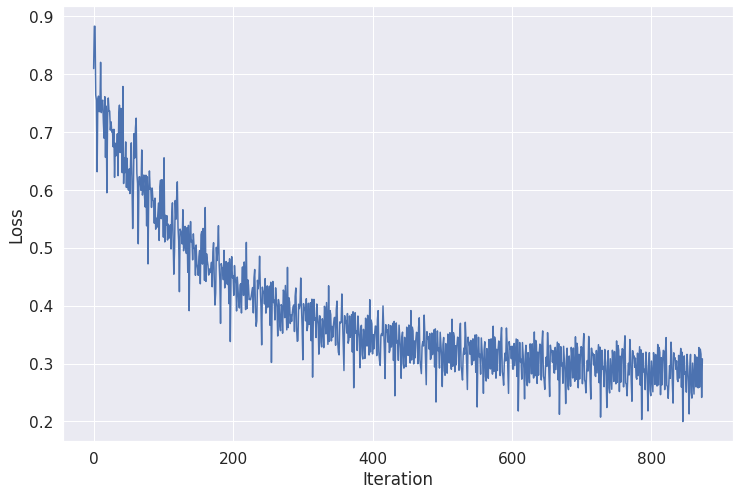

In [11]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

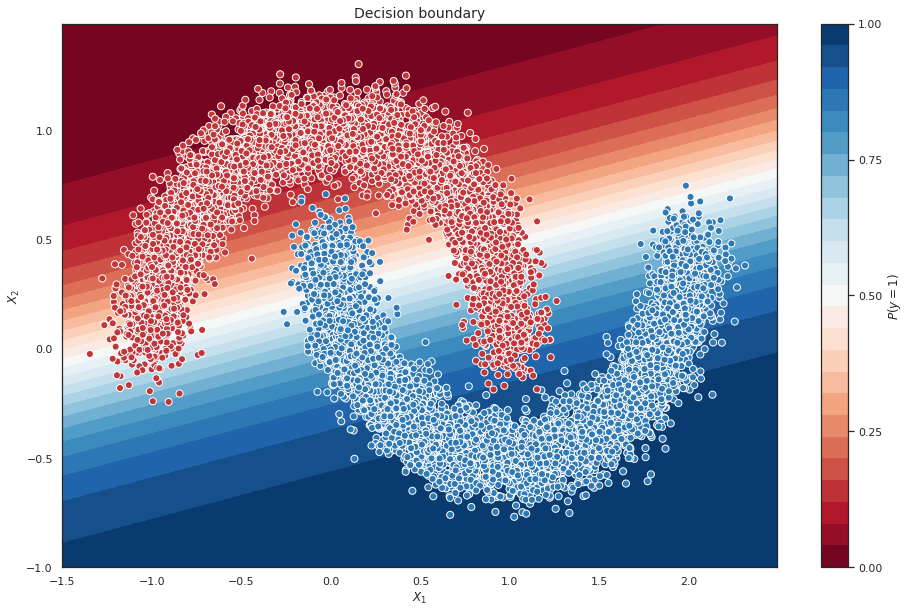

In [12]:
import numpy as np

sns.set(style='white')

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)
    
f, ax = plt.subplots(figsize=(16, 10))
ax.set_title('Decision boundary', fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap='RdBu', vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap='RdBu', vmin=-.2, vmax=1.2,
           edgecolor='white', linewidth=1)

ax.set(xlabel='$X_1$', ylabel='$X_2$')
plt.show()

<h3>Протестируем модель и посчитаем accuracy на test</h3>

In [53]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        preds = model(x_batch.float())
        probabilities = torch.sigmoid(preds)
        preds = (probabilities > 0.5).type(torch.long)
        predictions = np.hstack((predictions, preds.numpy().flatten()))   
    return predictions.flatten()
        
test_predict = predict(val_dataloader, linear_regression)

In [57]:
from sklearn.metrics import accuracy_score


print(f'Accuracy model: {accuracy_score(test_predict, y_val_t)}')

Accuracy model: 0.886
